In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Check GPU - False
print(torch.cuda.is_available())

# Extract files

'''
import zipfile

with zipfile.ZipFile('./data/images_background.zip') as z:
    z.extractall('.')

with zipfile.ZipFile('./data/images_evaluation.zip') as z:
    z.extractall('.')
'''

True


"\nimport zipfile\n\nwith zipfile.ZipFile('./data/images_background.zip') as z:\n    z.extractall('.')\n\nwith zipfile.ZipFile('./data/images_evaluation.zip') as z:\n    z.extractall('.')\n"

In [2]:
# Read data

def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    datax = []
    datay = []
    characteres = os.listdir(alphabet_directory_path)

    for character in characteres:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img), (28,28)
            )
            # rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270',
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    datax = None
    datay = None

    pool = mp.Pool(mp.cpu_count())

    results = [pool.apply(read_alphabets, args=(
                              base_directory + '/' + directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay


trainx, trainy = read_images('images_background')
testx, testy = read_images('images_evaluation')

print(trainx.shape, trainy.shape, testx.shape, testy.shape)

# Create sample

(77120, 28, 28, 3) (77120,) (52720, 28, 28, 3) (52720,)


In [3]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0,1,4,2,3)
    return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })       

In [4]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


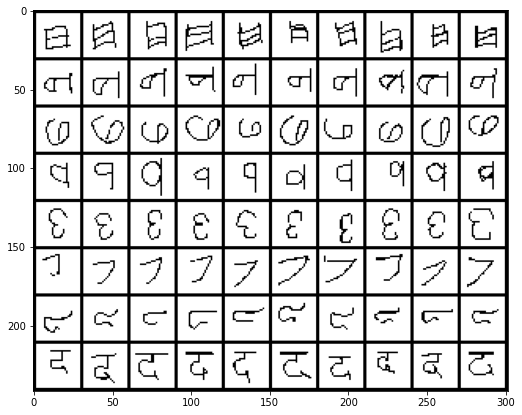

In [5]:

sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [6]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [8]:
def load_protonet_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
    return ProtoNet(encoder)

In [9]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
    
        sample_images = sample['images'].cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds.cuda()
   
    
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
        z = self.encoder.forward(x)
        z_dim = z.size(-1) #usually 64
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)
    
        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
        return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [10]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [11]:
# Train
# from tqdm import tqdm_notebook
# from tqdm import tnrange

In [19]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in range(epoch_size):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [13]:
print(torch.cuda.is_available())

True


In [20]:
model = load_protonet_conv(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 -- Loss: 0.1180 Acc: 0.9636
Epoch 2 -- Loss: 0.0473 Acc: 0.9834
Epoch 3 -- Loss: 0.0353 Acc: 0.9867
Epoch 4 -- Loss: 0.0293 Acc: 0.9888
Epoch 5 -- Loss: 0.0268 Acc: 0.9897


In [23]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  running_loss = 0.0
  running_acc = 0.0
  for episode in range(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [24]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

Test results -- Loss: 0.0200 Acc: 0.9958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


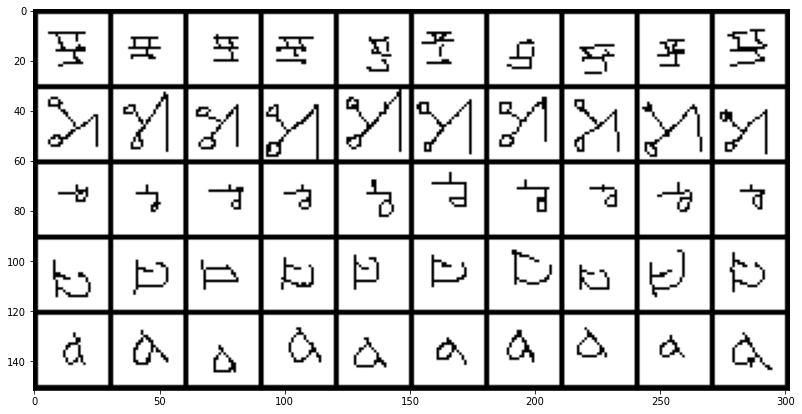

Exception ignored in: <function tqdm.__del__ at 0x7f4aa9bf8700>
Traceback (most recent call last):
  File "/home/maluarmini/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/maluarmini/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f4aa9bf8700>
Traceback (most recent call last):
  File "/home/maluarmini/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/maluarmini/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [25]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [26]:

my_loss, my_output = model.set_forward_loss(my_sample)

In [27]:
my_output

{'loss': 0.05755393207073212,
 'acc': 0.9599999785423279,
 'y_hat': tensor([[0, 2, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}

In [30]:
torch.save(model, 'model.pth')